# Subbundles Part 5: Clustering

**Subbundle** - a subgroup of streamlines with a set of common properties

In [1]:
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA

import scipy.cluster.hierarchy as spc
from scipy.cluster.hierarchy import dendrogram

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Streamline Profiles (from Part 3)

In [2]:
fa_values = np.load('fa_streamline_profile.npy')
fa_df = pd.DataFrame(fa_values.T)

md_values = np.load('md_streamline_profile.npy')
md_df = pd.DataFrame(fa_values.T)

## Adjacencies (From Part 4)

In [3]:
fa_corr = np.load('fa_adjacency.npy')
r2 = np.load('r2_adjacency.npy')
md_corr = np.load('md_adjacency.npy')
weighted = np.load('weighted_adjacency.npy')
mdf = np.load('mdf_adjacency.npy')

## Permute/reorder matrix by similarity

- this becomes convex optimization problem

- many clustering algorithms would work for this setup

### <span style="color:blue">**TODO**</span> [Dimensionality Reduction](https://en.wikipedia.org/wiki/Dimensionality_reduction)


- [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis) (*Principle Component Analysis*)

### <span style="color:red">NOTE: There are many [dimensionality reduction techniques](https://www.analyticsvidhya.com/blog/2018/08/dimensionality-reduction-techniques-python/) available to choose from.</span>

- <span style="color:red">**Question: Which others make sense to explore? and how to compare?**</span>

### PCA

#### FA

In [4]:
fa_pca = PCA(n_components=3)
fa_pca.fit(fa_corr)

# eigenvectors
print(fa_pca.components_.T)

# eigenvalues
print(fa_pca.explained_variance_)

# loadings
print(fa_pca.components_.T * np.sqrt(fa_pca.explained_variance_))

[[-0.06457591 -0.01515557  0.01595875]
 [-0.05660693 -0.01649725  0.08035302]
 [-0.06526218 -0.02825141  0.02509738]
 ...
 [ 0.0232992  -0.03287138 -0.05478583]
 [ 0.01746626 -0.06242172 -0.03808926]
 [ 0.02041222 -0.0487573  -0.05210312]]
[8.01141319 3.57120847 1.42299758]
[[-0.18277849 -0.02864045  0.01903711]
 [-0.16022275 -0.03117592  0.09585269]
 [-0.18472095 -0.0533885   0.02993853]
 ...
 [ 0.06594708 -0.06211916 -0.06535372]
 [ 0.04943726 -0.11796232 -0.04543648]
 [ 0.05777565 -0.0921398  -0.06215353]]


#### R2

In [5]:
r2_pca = PCA(n_components=3)
r2_pca.fit(r2)
print(r2_pca.components_.T)
print(r2_pca.explained_variance_)
print(r2_pca.components_.T * np.sqrt(r2_pca.explained_variance_))

[[ 0.01447495 -0.06491529 -0.04947803]
 [ 0.01646551 -0.06102921 -0.03370871]
 [ 0.01306852 -0.06276458 -0.02400349]
 ...
 [-0.00581261  0.04080912 -0.14809631]
 [-0.00255031  0.02717388 -0.1243706 ]
 [-0.00603924  0.04233161 -0.14863139]]
[234.01828996  47.42790365   7.10261259]
[[ 0.22143278 -0.44705812 -0.13186254]
 [ 0.25188371 -0.42029546 -0.08983617]
 [ 0.19991777 -0.43224664 -0.06397104]
 ...
 [-0.08891933  0.28104392 -0.39468744]
 [-0.03901371  0.18714087 -0.33145668]
 [-0.09238628  0.291529   -0.39611346]]


#### MD

In [6]:
md_pca = PCA(n_components=3)
md_pca.fit(md_corr)
print(md_pca.components_.T)
print(md_pca.explained_variance_)
print(md_pca.components_.T * np.sqrt(md_pca.explained_variance_))

[[ 0.03428641 -0.059654    0.04732385]
 [-0.01416393 -0.05921173  0.07004918]
 [-0.01327572 -0.06318149  0.05400332]
 ...
 [ 0.02258224 -0.05250529 -0.05285693]
 [ 0.01901015 -0.04237431 -0.06377379]
 [ 0.01745887 -0.05256762 -0.05661113]]
[6.01039827 3.26232758 0.87554853]
[[ 0.08405696 -0.10774654  0.04428128]
 [-0.03472445 -0.10694772  0.06554555]
 [-0.0325469  -0.11411787  0.05053131]
 ...
 [ 0.05536287 -0.0948346  -0.04945862]
 [ 0.04660549 -0.07653612 -0.05967361]
 [ 0.04280236 -0.09494719 -0.05297146]]


#### $\alpha$ FA + $\beta$ MD

In [7]:
weighted_pca = PCA(n_components=3)
weighted_pca.fit(weighted)

print(weighted_pca.components_.T)
print(weighted_pca.explained_variance_)
print(weighted_pca.components_.T * np.sqrt(weighted_pca.explained_variance_))

[[-0.02895363 -0.05996878  0.00746027]
 [-0.0511665  -0.03738844  0.04862523]
 [-0.0567746  -0.040446    0.01561369]
 ...
 [ 0.00516798 -0.00454038 -0.10477411]
 [-0.00635651  0.00714171 -0.0958856 ]
 [-0.00338313  0.00100637 -0.10390437]]
[4.43094273 3.37078623 0.75567172]
[[-0.06094683 -0.11010088  0.00648517]
 [-0.10770449 -0.06864405  0.04226961]
 [-0.11950943 -0.07425765  0.01357288]
 ...
 [ 0.01087849 -0.00833601 -0.09107948]
 [-0.01338032  0.01311196 -0.08335276]
 [-0.00712143  0.00184766 -0.09032342]]


#### MDF

In [8]:
mdf_pca = PCA(n_components=3)
mdf_pca.fit(mdf)

print(mdf_pca.components_.T)
print(mdf_pca.explained_variance_)
print(mdf_pca.components_.T * np.sqrt(mdf_pca.explained_variance_))

[[-0.02973731  0.05445142  0.03112469]
 [-0.05097225  0.05128423  0.02762655]
 [-0.05060448  0.05763913  0.01918098]
 ...
 [-0.00220233 -0.01317581  0.10730599]
 [-0.01074682 -0.01240091  0.10761763]
 [-0.00371128 -0.0137827   0.10425015]]
[3462.61446608 1908.27850682  760.4869881 ]
[[-1.74986196  2.37864758  0.85832343]
 [-2.99941005  2.24029264  0.76185536]
 [-2.97776913  2.5178989   0.5289525 ]
 ...
 [-0.12959394 -0.57557018  2.95916954]
 [-0.63238543 -0.54171962  2.96776362]
 [-0.21838652 -0.60208157  2.87489901]]


#### NOTE that the eigenvectors are very short and hard to see in this

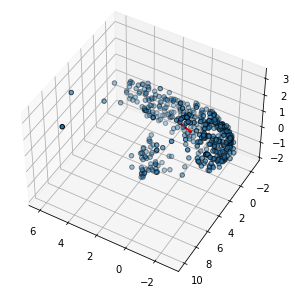

In [9]:
weighted_X = weighted_pca.transform(weighted)


fig = plt.figure(figsize=(5, 5))

ax = Axes3D(fig, rect=[0, 0, 0.75, 1], elev=45, azim=120)
sc = ax.scatter(weighted_X[:, 0], weighted_X[:, 1], weighted_X[:, 2], edgecolor='k')

for v in weighted_pca.components_:
    ax.quiver(
        weighted_pca.mean_[0],  weighted_pca.mean_[1],  weighted_pca.mean_[2], # <-- starting point of vector
        v[0] - weighted_pca.mean_[0], v[1] -  weighted_pca.mean_[1], v[2] -  weighted_pca.mean_[2], # <-- directions of vector
        arrow_length_ratio=0.1, color='red'
    )

#### WARNING: Using clustering results from below to color code clusters

## Clustering

- For every streamline assign class given collection in unsupervised manner

  - Then label clusters
    
    - To identify number of clusters use empirical test like F-test

- [Spectral Clustering](https://en.wikipedia.org/wiki/Spectral_clustering) in [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html)

### <span style="color:blue">**TODO: Gaussian mixture models**</span>

https://scikit-learn.org/stable/modules/mixture.html#mixture

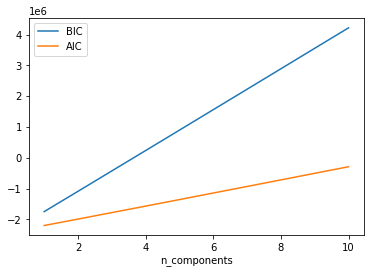

In [10]:
from sklearn.mixture import GaussianMixture
n_components = np.arange(1, 11)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(fa_corr) for n in n_components]
plt.plot(n_components, [m.bic(fa_corr) for m in models], label='BIC')
plt.plot(n_components, [m.aic(fa_corr) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

In [11]:
gmm = GaussianMixture(n_components=3)

gmm.fit(fa_corr)
gmm_fa_idx = gmm.predict(fa_corr)
np.save('gmm_fa_idx.npy', gmm_fa_idx)

gmm.fit(r2)
gmm_r2_idx = gmm.predict(r2)
np.save('gmm_r2_idx.npy', gmm_r2_idx)

gmm.fit(md_corr)
gmm_md_idx = gmm.predict(md_corr)
np.save('gmm_md_idx.npy', gmm_md_idx)

gmm.fit(weighted)
gmm_weighted_idx = gmm.predict(weighted)
np.save('gmm_weighted_idx.npy', gmm_weighted_idx)

gmm.fit(mdf)
gmm_mdf_idx = gmm.predict(mdf)
np.save('gmm_mdf_idx.npy', gmm_mdf_idx)

### <span style="color:blue">**TODO: MeanShift**</span>

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MeanShift.html#sklearn.cluster.MeanShift

In [12]:
from sklearn.cluster import MeanShift
ms_fa_idx = MeanShift().fit(fa_corr).labels_
np.save('ms_fa_idx.npy', ms_fa_idx)
ms_r2_idx = MeanShift().fit(r2).labels_
np.save('ms_r2_idx.npy', ms_r2_idx)
ms_md_idx = MeanShift().fit(md_corr).labels_
np.save('ms_md_idx.npy', ms_md_idx)
ms_weighted_idx = MeanShift().fit(weighted).labels_
np.save('ms_weighted_idx.npy', ms_weighted_idx)
ms_mdf_idx = MeanShift().fit(mdf).labels_
np.save('ms_mdf_idx.npy', ms_mdf_idx)

### Hierarchical Clusters

Following example from:

https://stackoverflow.com/questions/52787431/create-clusters-using-correlation-matrix-in-python/52787518#52787518

Using [`scipy.cluster` Hierarchical Clustering package](https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html#module-scipy.cluster.hierarchy)

- see https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html#module-scipy.cluster.hierarchy

### <span style="color:red">NOTE: This represents a first attempt</span> 

- No thought put into algorithm choice or hyperparameters.

<span style="color:blue">**TODO: be intentional in how determining clusters**</span>

### <span style="color:red">NOTE: The dendrogram can be used to manually tune the threshold to desired number of clusters.</span>

- Here setting `p` level to `1` since expect SLF bundle to have 2 or 3 subbundles

### <span style="color:red">NOTE: Manually setting threshold based on dendrogram</span>

- However, it would be better to learn threshold

<span style="color:blue">**TODO: Elaborate what is a "flat cluster"**</span>

##### FA

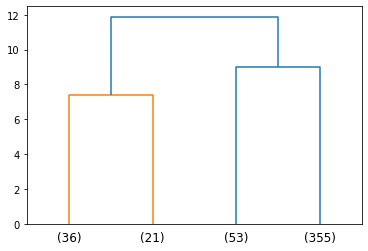

In [13]:
# Pairwise distances between observations in n-dimensional space
fa_pdist = spc.distance.pdist(fa_corr)

# Perform hierarchical clustering
fa_linkage = spc.linkage(fa_pdist, method='complete')

dendrogram(fa_linkage, p=1, truncate_mode='level', show_leaf_counts=True)
plt.show()

In [14]:
# Threshold to apply when forming flat clusters
fa_cluster_threshold = 8/12 * fa_pdist.max()

# Forms flat clusters from the hierarchical clustering defined by the given linkage matrix
# so that the original observations in each flat cluster have no greater a cophenetic distance 
# than cluster_threshold
fa_idx = spc.fcluster(fa_linkage, fa_cluster_threshold, 'distance')
np.save('fa_idx.npy', fa_idx)

print("number of clusters:", len(np.unique(fa_idx)))

number of clusters: 3


#### R2

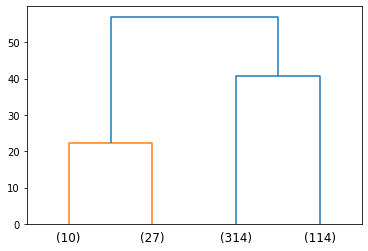

In [15]:
r2_pdist = spc.distance.pdist(r2)
r2_linkage = spc.linkage(r2_pdist, method='complete')

dendrogram(r2_linkage, p=1, truncate_mode='level', show_leaf_counts=True)
plt.show()

In [16]:
r2_cluster_threshold = 40/60 * r2_pdist.max()
r2_idx = spc.fcluster(r2_linkage, r2_cluster_threshold, 'distance')
np.save('r2_idx.npy', r2_idx)

print("number of clusters:", len(np.unique(r2_idx)))

number of clusters: 3


##### MD

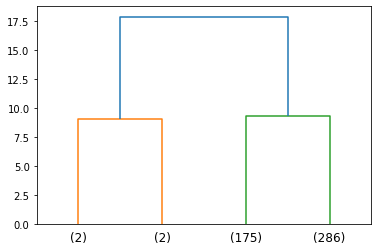

In [17]:
# Pairwise distances between observations in n-dimensional space
md_pdist = spc.distance.pdist(md_corr)

# Perform hierarchical clustering
md_linkage = spc.linkage(md_pdist, method='complete')

dendrogram(md_linkage, p=1, truncate_mode='level', show_leaf_counts=True)
plt.show()

In [18]:
md_cluster_threshold = 18/35 * md_pdist.max()
md_idx = spc.fcluster(md_linkage, md_cluster_threshold, 'distance')
np.save('md_idx.npy', md_idx)

print("number of clusters:", len(np.unique(md_idx)))

number of clusters: 3


##### $\alpha$ FA + $\beta$ MD

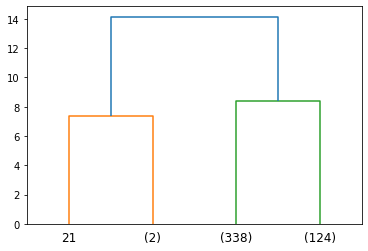

In [19]:
weighted_pdist = spc.distance.pdist(weighted)
weighted_linkage = spc.linkage(weighted_pdist, method='complete')

dendrogram(weighted_linkage, p=1, truncate_mode='level', show_leaf_counts=True)
plt.show()

In [20]:
weighted_cluster_threshold = 8/14 * weighted_pdist.max()
weighted_idx = spc.fcluster(weighted_linkage, weighted_cluster_threshold, 'distance')
np.save('weighted_idx.npy', weighted_idx)

print("number of clusters:", len(np.unique(weighted_idx)))

number of clusters: 3


#### MDF

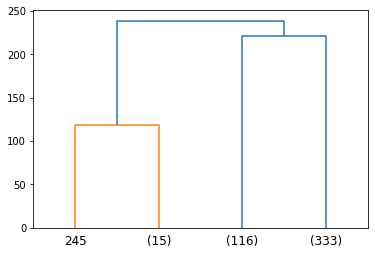

In [21]:
mdf_pdist = spc.distance.pdist(mdf)
mdf_linkage = spc.linkage(mdf_pdist, method='complete')

dendrogram(mdf_linkage, p=1, truncate_mode='level', show_leaf_counts=True)
plt.show()

In [22]:
mdf_cluster_threshold = 200/240 * mdf_pdist.max()
mdf_idx = spc.fcluster(mdf_linkage, mdf_cluster_threshold, 'distance')
np.save('mdf_idx.npy', mdf_idx)

print("number of clusters:", len(np.unique(mdf_idx)))

number of clusters: 3


## Resort the matrix based on cluster

#### FA

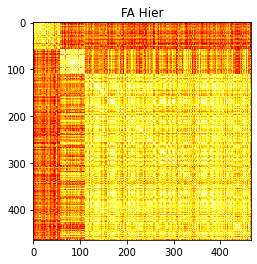

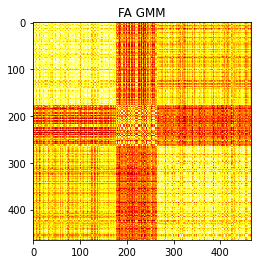

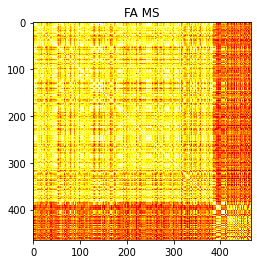

In [23]:
fa_columns = [fa_df.columns.tolist()[i] for i in list((np.argsort(fa_idx)))]
fa_clust_df = fa_df.reindex(fa_columns, axis=1)
fa_clust_corr = fa_clust_df.corr()

plt.title('FA Hier')
plt.imshow(fa_clust_corr, cmap='hot', interpolation='nearest')
plt.show()

fa_columns = [fa_df.columns.tolist()[i] for i in list((np.argsort(gmm_fa_idx)))]
fa_clust_df = fa_df.reindex(fa_columns, axis=1)
fa_clust_corr = fa_clust_df.corr()

plt.title('FA GMM')
plt.imshow(fa_clust_corr, cmap='hot', interpolation='nearest')
plt.show()

fa_columns = [fa_df.columns.tolist()[i] for i in list((np.argsort(ms_fa_idx)))]
fa_clust_df = fa_df.reindex(fa_columns, axis=1)
fa_clust_corr = fa_clust_df.corr()

plt.title('FA MS')
plt.imshow(fa_clust_corr, cmap='hot', interpolation='nearest')
plt.show()

#### R2

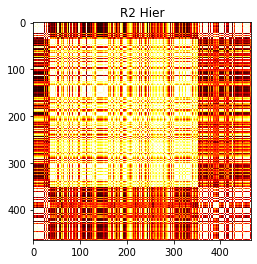

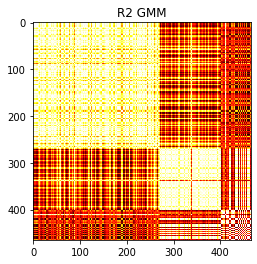

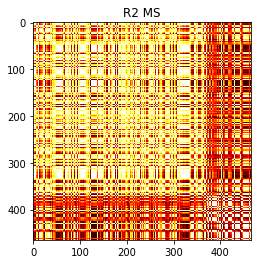

In [24]:
r2_df = pd.DataFrame.from_records(r2)
r2_columns = [r2_df.columns.tolist()[i] for i in list((np.argsort(r2_idx)))]
r2_clust_df = r2_df.reindex(r2_columns, axis=1)
r2_clust_corr = r2_clust_df.corr()

plt.title('R2 Hier')
plt.imshow(r2_clust_corr, cmap='hot', interpolation='nearest')
plt.show()

r2_columns = [r2_df.columns.tolist()[i] for i in list((np.argsort(gmm_r2_idx)))]
r2_clust_df = r2_df.reindex(r2_columns, axis=1)
r2_clust_corr = r2_clust_df.corr()

plt.title('R2 GMM')
plt.imshow(r2_clust_corr, cmap='hot', interpolation='nearest')
plt.show()

r2_columns = [r2_df.columns.tolist()[i] for i in list((np.argsort(ms_r2_idx)))]
r2_clust_df = r2_df.reindex(r2_columns, axis=1)
r2_clust_corr = r2_clust_df.corr()

plt.title('R2 MS')
plt.imshow(r2_clust_corr, cmap='hot', interpolation='nearest')
plt.show()

##### MD

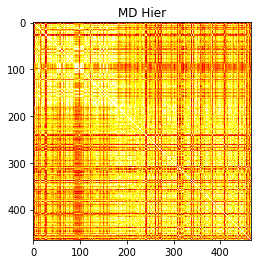

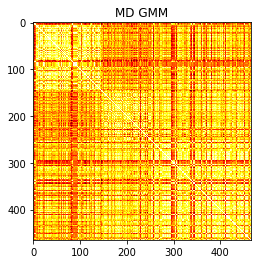

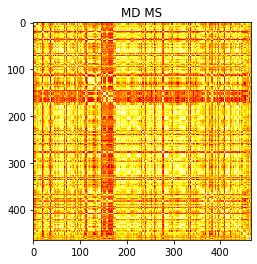

In [25]:
md_columns = [md_df.columns.tolist()[i] for i in list((np.argsort(md_idx)))]
md_clust_df = md_df.reindex(md_columns, axis=1)
md_clust_corr = md_clust_df.corr()

plt.title('MD Hier')
plt.imshow(md_clust_corr, cmap='hot', interpolation='nearest')
plt.show()

md_columns = [md_df.columns.tolist()[i] for i in list((np.argsort(gmm_md_idx)))]
md_clust_df = md_df.reindex(md_columns, axis=1)
md_clust_corr = md_clust_df.corr()

plt.title('MD GMM')
plt.imshow(md_clust_corr, cmap='hot', interpolation='nearest')
plt.show()

md_columns = [md_df.columns.tolist()[i] for i in list((np.argsort(ms_md_idx)))]
md_clust_df = md_df.reindex(md_columns, axis=1)
md_clust_corr = md_clust_df.corr()

plt.title('MD MS')
plt.imshow(md_clust_corr, cmap='hot', interpolation='nearest')
plt.show()

##### $\alpha$ FA + $\beta$ MD

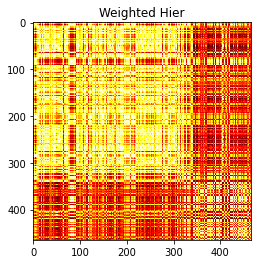

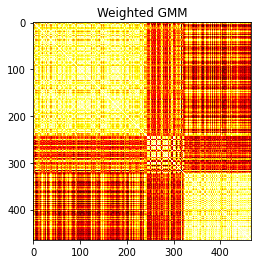

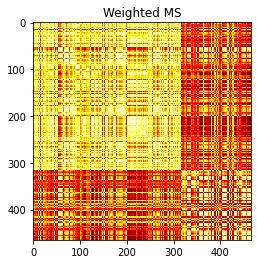

In [26]:
weighted_df = pd.DataFrame.from_records(weighted)

weighted_columns = [weighted_df.columns.tolist()[i] for i in list((np.argsort(weighted_idx)))]
weighted_clust_df = weighted_df.reindex(weighted_columns, axis=1)
weighted_clust_corr = weighted_clust_df.corr()

plt.title('Weighted Hier')
plt.imshow(weighted_clust_corr, cmap='hot', interpolation='nearest')
plt.show()

weighted_columns = [weighted_df.columns.tolist()[i] for i in list((np.argsort(gmm_weighted_idx)))]
weighted_clust_df = weighted_df.reindex(weighted_columns, axis=1)
weighted_clust_corr = weighted_clust_df.corr()

plt.title('Weighted GMM')
plt.imshow(weighted_clust_corr, cmap='hot', interpolation='nearest')
plt.show()

weighted_columns = [weighted_df.columns.tolist()[i] for i in list((np.argsort(ms_weighted_idx)))]
weighted_clust_df = weighted_df.reindex(weighted_columns, axis=1)
weighted_clust_corr = weighted_clust_df.corr()

plt.title('Weighted MS')
plt.imshow(weighted_clust_corr, cmap='hot', interpolation='nearest')
plt.show()

#### MDF

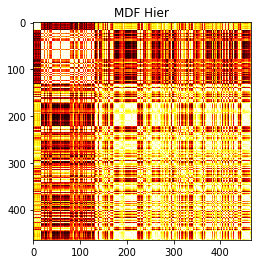

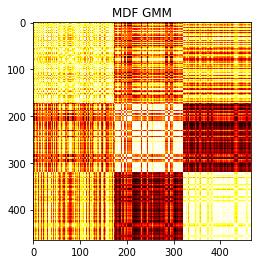

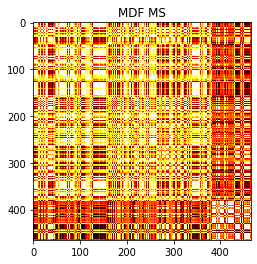

In [27]:
mdf_df = pd.DataFrame.from_records(mdf)

mdf_columns = [mdf_df.columns.tolist()[i] for i in list((np.argsort(mdf_idx)))]
mdf_clust_df = mdf_df.reindex(mdf_columns, axis=1)
mdf_clust_corr = mdf_clust_df.corr()

plt.title('MDF Hier')
plt.imshow(mdf_clust_corr, cmap='hot', interpolation='nearest')
plt.show()

mdf_columns = [mdf_df.columns.tolist()[i] for i in list((np.argsort(gmm_mdf_idx)))]
mdf_clust_df = mdf_df.reindex(mdf_columns, axis=1)
mdf_clust_corr = mdf_clust_df.corr()

plt.title('MDF GMM')
plt.imshow(mdf_clust_corr, cmap='hot', interpolation='nearest')
plt.show()

mdf_columns = [mdf_df.columns.tolist()[i] for i in list((np.argsort(ms_mdf_idx)))]
mdf_clust_df = mdf_df.reindex(mdf_columns, axis=1)
mdf_clust_corr = mdf_clust_df.corr()

plt.title('MDF MS')
plt.imshow(mdf_clust_corr, cmap='hot', interpolation='nearest')
plt.show()